# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('D:/Work/database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
#final['Score'].value_counts()

#sampling 100k points
pos = final[final['Score']==1].sample(n = 20000)
neg = final[final['Score']==0].sample(n = 20000)
final_ = pd.concat([pos,neg])
print("Sampled data: ", final_.shape)

(364171, 10)
Sampled data:  (40000, 10)


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final_['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final_['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final_['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final_['Text'].values[4900]
print(sent_4900)
print("="*50)

"thinkThin Chocolate Fudge, 2.1-Ounce Bar (Pack of 10)" taste excellent so long as they are always kept at a temperature above 40 degrees Fahrenheit and below 80 degrees Fahrenheit. I live in the desert southwest, so when I first ordered these from Amazon last summer, and it was well over 110 degrees Fahrenheit, what I received was a mess, so I put them in the Fridge. Went from too hot to too cold, the taste was gritty and messy as the chocolate enrobing shattered and fell off, still better than 110 degree puddles I was first presented.  Now that it's winter, and the weather is between 40 and 70 degrees Fahrenheit, every bar I have received from Amazon has been perfect. I store the bars at room temperature. The bars are smooth, moist and chewy, perfect in all the ways I expected.  I will need to order a 6 month supply before May if I want to enjoy these bars during the very hot summer months. So, for everyone who is having taste troubles with these particular bars, try to schedule a sh

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

"thinkThin Chocolate Fudge, 2.1-Ounce Bar (Pack of 10)" taste excellent so long as they are always kept at a temperature above 40 degrees Fahrenheit and below 80 degrees Fahrenheit. I live in the desert southwest, so when I first ordered these from Amazon last summer, and it was well over 110 degrees Fahrenheit, what I received was a mess, so I put them in the Fridge. Went from too hot to too cold, the taste was gritty and messy as the chocolate enrobing shattered and fell off, still better than 110 degree puddles I was first presented.  Now that it's winter, and the weather is between 40 and 70 degrees Fahrenheit, every bar I have received from Amazon has been perfect. I store the bars at room temperature. The bars are smooth, moist and chewy, perfect in all the ways I expected.  I will need to order a 6 month supply before May if I want to enjoy these bars during the very hot summer months. So, for everyone who is having taste troubles with these particular bars, try to schedule a sh

In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

"thinkThin Chocolate Fudge, 2.1-Ounce Bar (Pack of 10)" taste excellent so long as they are always kept at a temperature above 40 degrees Fahrenheit and below 80 degrees Fahrenheit. I live in the desert southwest, so when I first ordered these from Amazon last summer, and it was well over 110 degrees Fahrenheit, what I received was a mess, so I put them in the Fridge. Went from too hot to too cold, the taste was gritty and messy as the chocolate enrobing shattered and fell off, still better than 110 degree puddles I was first presented.  Now that it's winter, and the weather is between 40 and 70 degrees Fahrenheit, every bar I have received from Amazon has been perfect. I store the bars at room temperature. The bars are smooth, moist and chewy, perfect in all the ways I expected.  I will need to order a 6 month supply before May if I want to enjoy these bars during the very hot summer months. So, for everyone who is having taste troubles with these particular bars, try to schedule a sh

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Nice strong brew to get your morning jump started!  I do not display the cups since the filter shows, but that is not a problem for me.  Hopefully, it is less waste for the enviroment.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

"thinkThin Chocolate Fudge,  Bar (Pack of  taste excellent so long as they are always kept at a temperature above  degrees Fahrenheit and below  degrees Fahrenheit. I live in the desert southwest, so when I first ordered these from Amazon last summer, and it was well over  degrees Fahrenheit, what I received was a mess, so I put them in the Fridge. Went from too hot to too cold, the taste was gritty and messy as the chocolate enrobing shattered and fell off, still better than  degree puddles I was first presented.  Now that it's winter, and the weather is between  and  degrees Fahrenheit, every bar I have received from Amazon has been perfect. I store the bars at room temperature. The bars are smooth, moist and chewy, perfect in all the ways I expected.  I will need to order a  month supply before May if I want to enjoy these bars during the very hot summer months. So, for everyone who is having taste troubles with these particular bars, try to schedule a shipment when your local weath

In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Nice strong brew to get your morning jump started I do not display the cups since the filter shows but that is not a problem for me Hopefully it is less waste for the enviroment 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final_['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:13<00:00, 2982.82it/s]


In [23]:
final_['CleanedText'] = preprocessed_reviews
preprocessed_reviews[1500]

'nice strong brew get morning jump started not display cups since filter shows not problem hopefully less waste enviroment'

# [4] Featurization

## [4.1] TF-IDF

In [24]:
tf_idf_vect = TfidfVectorizer(min_df=10)
final_tfidf = tf_idf_vect.fit_transform(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])

some sample features(unique words in the corpus) ['abandoned', 'abdominal', 'ability', 'able', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed']


# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [25]:
fn = tf_idf_vect.get_feature_names()
# Code From -> https://buhrmann.github.io/tfidf-analysis.html 
def get_top_n_features(row, features, top_n): #Function takes in a row.
    # returns a dataframe with top n features :
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [26]:
tfidf_mean = np.mean(final_tfidf, axis = 0)
print(tfidf_mean)
tfidf_mean = np.array(tfidf_mean)[0].tolist()

top_feat = get_top_n_features(tfidf_mean, fn, 2000)
top_feat.shape

[[  8.06670566e-05   4.63611817e-05   1.87888741e-04 ...,   7.10712020e-05
    8.72895507e-05   1.43238801e-04]]


(2000, 2)

In [27]:
top_feat.head()

,feature,tfidf
0,not,0.051570
1,like,0.027730
2,product,0.023790
3,taste,0.023721
4,good,0.023131


### [5.2] Co-occurance matrix

In [41]:
def co_occur(data, n_features):
    
    tfidf = TfidfVectorizer(max_features=n_features)
    tfidf_data = tfidf.fit_transform(data['CleanedText'].values)
    fn = tfidf.get_feature_names()
    tfidf_mean = np.mean(tfidf_data, axis = 0)
    tfidf_mean = np.array(tfidf_mean)[0].tolist()
    top_feat = get_top_n_features(tfidf_mean, fn, n_features)

    a = np.zeros((n_features,n_features))
    df = pd.DataFrame(a, index=fn, columns=fn)
    for sent in tqdm(preprocessed_reviews):
        #sent = sent.decode('utf-8')
        words = sent.split(" ")
        for i, words_ in enumerate(words):
            for j in range(max(i - 5, 0),min(i + 5, len(words) - 1) + 1): # checking for 5 neighbours for a word to be in context to another word.
                if(i + j < len(words) and words[i] != words[j]):
                    try:
                        df.loc[words[i], words[j]] += 1 # proximity i -> j
                        df.loc[words[j], words[i]] += 1 # proximity j -> i
                    except:
                        pass
    return df

In [42]:
df = co_occur(final_, 2000)

100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [1:31:49<00:00,  7.26it/s]


In [43]:
pd.DataFrame(df).head()

,able,absolutely,acceptable,according,acid,acidic,across,actual,actually,add,...,yes,yesterday,yet,yogurt,young,yuck,yum,yummy,zero,zico
able,0.0,4.0,4.0,0.0,10.0,0.0,2.0,12.0,4.0,14.0,...,4.0,0.0,6.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0
absolutely,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,10.0,...,4.0,2.0,4.0,0.0,0.0,2.0,0.0,10.0,18.0,0.0
acceptable,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
according,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,4.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acid,10.0,0.0,0.0,4.0,0.0,2.0,0.0,2.0,2.0,4.0,...,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from wordcloud import WordCloud

k = [500,700,900,1100,1300,1500]
var = []
svd_ = 0
max_var = -1
for c in tqdm(k):
    svd = TruncatedSVD(n_components=c)
    svd.fit(df)
    exp_var_sum = svd.explained_variance_ratio_.sum()
    var.append(exp_var_sum)
    if exp_var_sum > max_var:
        svd_ = svd
        max_var = exp_var_sum

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  2.31s/it]


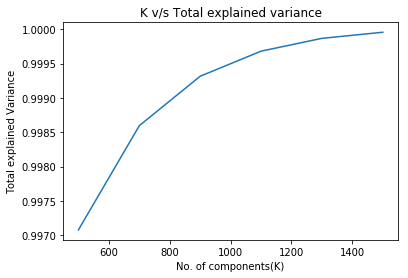

In [45]:
import matplotlib.pyplot as plt

plt.plot(k, var)
plt.title('K v/s Total explained variance')
plt.xlabel('No. of components(K)') 
plt.ylabel('Total explained Variance')
plt.show()

Maximum explained variance is with k = 1500, and last iteration was with 1500 components hence no need to fit again.

In [46]:
U = svd_.transform(df)
#print("U: ",U.shape)
V_T = svd_.components_
#print("V_T: ",V_T.shape)
# sigma

shape = svd_.singular_values_.shape[0]
sigma = np.zeros((shape,shape))
for i in range(shape):
    sigma[i, i] = svd_.singular_values_[i]

In [47]:
print('U =', U.shape)
print("******************************")
print('V_T = ', V_T.shape)
print("******************************")
print('Sigma = ', sigma.shape)

U = (2000, 1500)
******************************
V_T =  (1500, 2000)
******************************
Sigma =  (1500, 1500)


### [5.3] K-means Clustering

In [48]:
k = list(range(2,11)) # number of clusters

loss = []

for cluster in tqdm(k):
    
    kmeans = KMeans(n_clusters = cluster, n_jobs = -1, verbose=1).fit(U)
    loss.append(kmeans.inertia_)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:47<00:00,  5.63s/it]


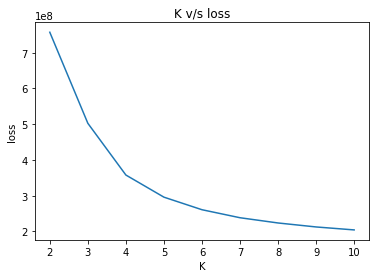

In [49]:
plt.plot(k,loss)
plt.title('K v/s loss')
plt.xlabel('K')
plt.ylabel('loss')
plt.show()

for k = 10 

In [50]:
model = KMeans(n_clusters = 10, n_jobs = -1)
model.fit(U)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [51]:
labeled_U = pd.DataFrame(U)
labeled_U['cluster_label'] = model.labels_
labeled_U['Words'] = top_feat['feature']
#print(labeled_U['Words'])
a = labeled_U.groupby(['cluster_label'])
a.count()

,0,1,2,3,4,5,6,7,8,9,...,1491,1492,1493,1494,1495,1496,1497,1498,1499,Words
cluster_label,,,,,,,,,,,,,,,,,,,,,
0,319,319,319,319,319,319,319,319,319,319,...,319,319,319,319,319,319,319,319,319,319
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,33,33,33,33,33,33,33,33,33,33,...,33,33,33,33,33,33,33,33,33,33
4,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
5,111,111,111,111,111,111,111,111,111,111,...,111,111,111,111,111,111,111,111,111,111
6,1518,1518,1518,1518,1518,1518,1518,1518,1518,1518,...,1518,1518,1518,1518,1518,1518,1518,1518,1518,1518
7,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
8,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


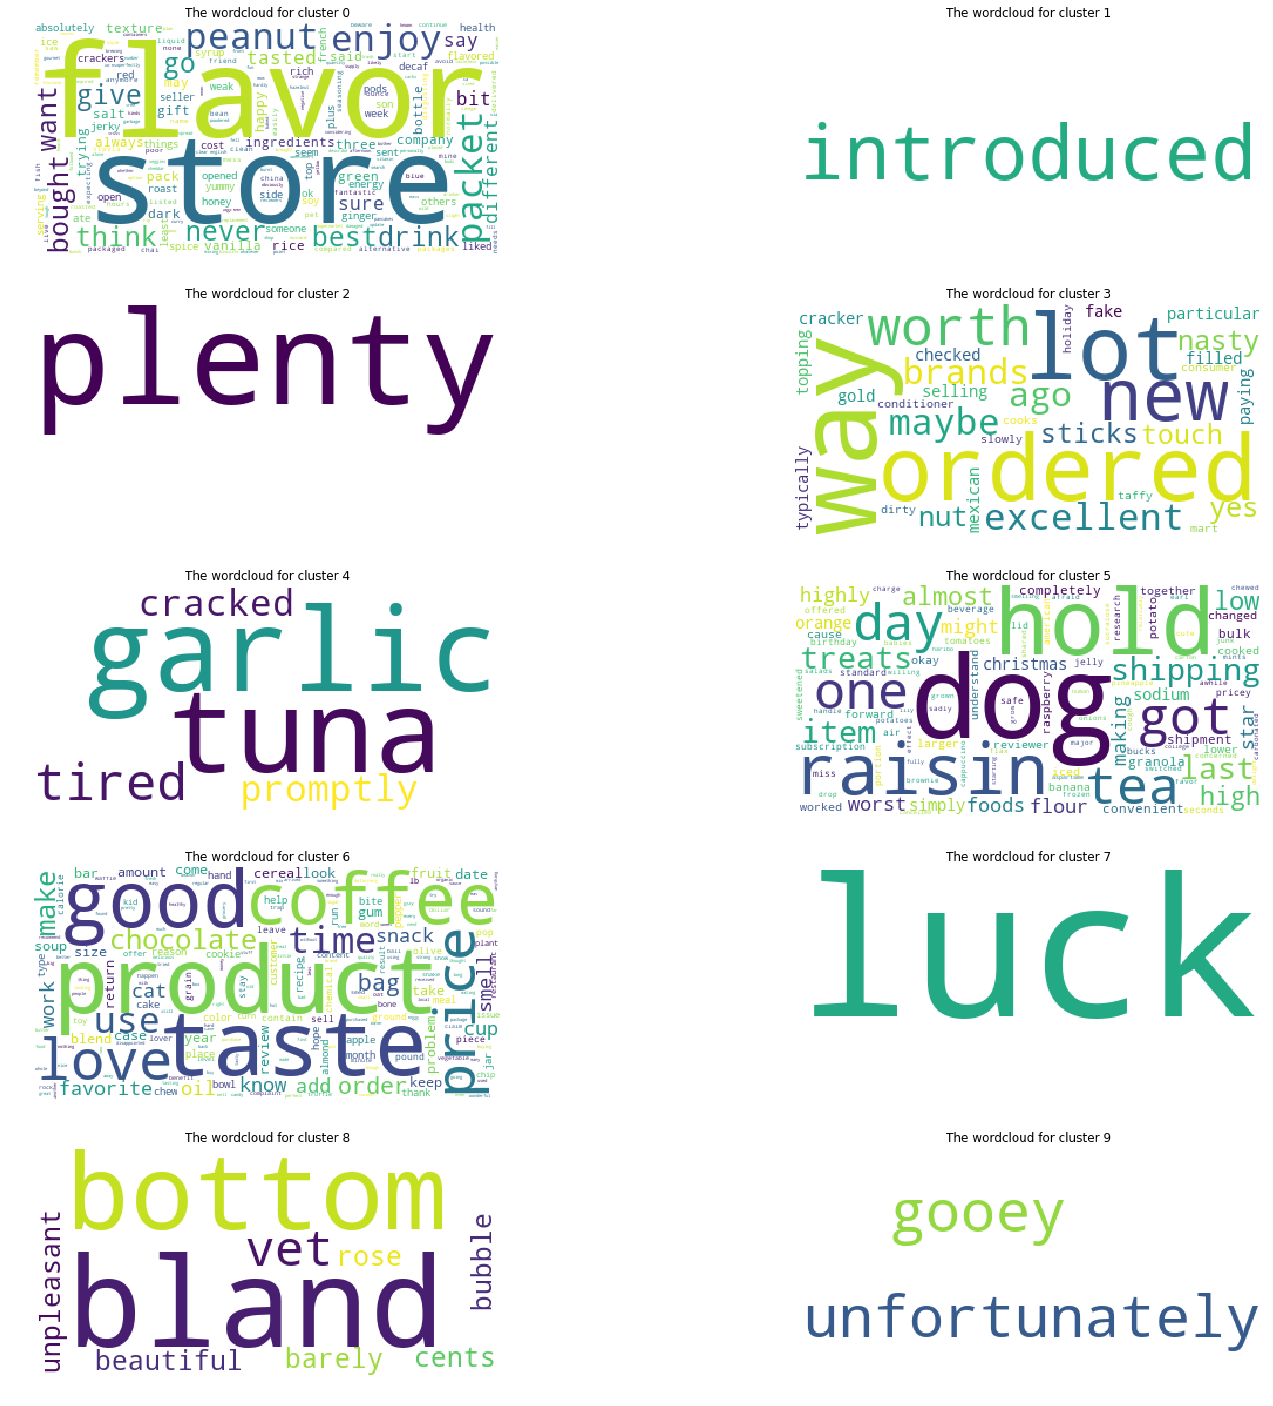

In [52]:
sentance = []
for i in range(0,10):
    s = ' '
    for x in a.groups[i]:
        s += labeled_U.loc[x,'Words']
        s += ' '
    sentance.append(s)

from wordcloud import WordCloud, STOPWORDS

fig, ax = plt.subplots(nrows = 5, ncols= 2,figsize=(25,25))
j = 0
k = 0
for i in range(10):
    wordcloud = WordCloud(background_color='white', stopwords = set(STOPWORDS)).generate(sentance[i])
    ax[k][j].imshow(wordcloud)
    ax[k][j].set_title('The wordcloud for cluster {}'.format(i))
    ax[k][j].axis('off')
    j = (j+1)%2
    if j == 0 and i >= 0:
        k = k + 1       
plt.show()

In [53]:
U_df = pd.DataFrame(U)
U_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,495.519947,-158.631400,-120.741866,13.004863,18.107594,-1.496936,-19.734224,21.764584,15.071812,73.092031,...,-0.289356,0.633227,0.323877,0.475419,-0.027385,-0.014965,0.356306,0.143682,0.022215,0.118940
1,535.799751,-24.685828,-52.663039,12.304799,54.461819,22.902627,107.650467,11.641597,9.818419,31.923608,...,0.235932,0.088039,0.188465,0.087288,-0.100565,-0.188262,-0.132522,0.273164,-0.016495,-0.147620
2,50.463299,-15.927558,1.807625,12.230529,1.390818,-3.895039,-9.740798,5.042304,6.100012,2.095454,...,-0.104953,-0.020515,0.239049,0.077962,-0.217273,0.816180,0.371078,0.099965,-0.203988,0.313123
3,99.785617,-6.413677,-22.130407,3.454392,6.274028,-11.807914,15.401032,11.047202,8.080509,-21.946984,...,-0.005861,0.577074,0.103190,0.092261,-0.294921,0.475447,-0.377866,1.047392,-0.446155,0.173390
4,148.158868,-10.530540,19.122229,19.847332,22.287813,-40.145147,19.155006,27.449363,7.975645,-8.454096,...,0.425383,-0.373188,-0.242969,-0.373876,-0.318775,0.034291,0.505403,0.524830,-0.046684,-0.269380


### [5.4] Getting similar words

In [54]:
from sklearn.metrics.pairwise import cosine_similarity
def get_sim_words(word):
    sim = cosine_similarity(U)
    #print(sim.shape)
    w_vect = sim[fn.index(word)]
    p = w_vect.argsort()[::-1][1:11]
    print('The 10 most similar words to {} are: '.format(word))
    for i in range(10):
        print(fn[p[i]])

In [55]:
get_sim_words(fn[1])

The 10 most similar words to abdominal are: 
buttermilk
boxed
bf
baggies
brush
crumbling
belgium
derived
del
acidic


In [56]:
get_sim_words(fn[1500])

The 10 most similar words to connected are: 
decafs
area
answer
bow
anxiously
countless
debate
carbon
cash
atleast


In [57]:
get_sim_words('delicious')

The 10 most similar words to delicious are: 
alter
deeply
butterscotch
blast
banned
also
decided
caring
biodegradable
daughter


In [58]:
get_sim_words('black')

The 10 most similar words to black are: 
brownie
deserve
absorb
bothers
acquire
criticism
cherry
boneless
barilla
canine


# [6] Conclusions

For this task following things have been done:
* Getting the top 2000 features after featurizing the review text with TF-IDF vectorizer.
* Creating a co-occurance matix of these 2000 features.
* Then for the decomposition of the co-occurance matrix, the right value 'k' was found by looking for the one with the highest explained variance and from the plotted graph, it turned out to be 1500 out of the all k values the explained variance was checked on. 
* Now, with these 1500 components, the matrix was decomposed into U, sigma and V_T(V Transpose).
* Thus found matrix U was used to create clusters using k-means clustering technique and the words were clustered and visualized nicely in the word clouds.
* finally a function 'get_sim_words' was written which takes a word as an arguement and returns 10 most similar words to it.